In [1]:
import numpy as np

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

np.random.seed(123)
torch.manual_seed(123)

# Use some real data - river-dl

In [2]:
# data from Simon's ~June 2022 river-dl run
river_dl = np.load("../../../Downloads/prepped_365_1.npz", allow_pickle = True)

# Subsetting data to
#    last year of data, (last batch of 455)
#    180-day sequences (second half of the water? year)
#    first 7 input vars (redundant now)
x = torch.from_numpy(river_dl['x_trn']).float()[-455:, -180:, :7]
y = torch.from_numpy(river_dl['y_obs_trn']).float()[-455:, -180:]

adj_matrix = river_dl['dist_matrix']
batch_size = adj_matrix.shape[0]

x.shape, y.shape, adj_matrix.shape

(torch.Size([455, 180, 7]), torch.Size([455, 180, 1]), (455, 455))

# Define RGCN v1

In [3]:
## RGCN - This version follows the published version of the RGCN by Jia et al. (2020)
# https://doi.org/10.1137/1.9781611976700.69
class RGCN_v1(nn.Module):
    # Built off of https://towardsdatascience.com/building-a-lstm-by-hand-on-pytorch-59c02a4ec091
    def __init__(self, input_dim, hidden_dim, adj_matrix, recur_dropout=0, dropout=0, return_states=False, device='cpu'):
        """
        @param input_dim: [int] number input feature
        @param hidden_dim: [int] hidden size
        @param adj_matrix: Distance matrix for graph convolution
        @param recur_dropout: [float] fraction of the units to drop from the cell update vector. See: https://arxiv.org/abs/1603.05118
        @param dropout: [float] fraction of the units to drop from the input
        @param return_states: [bool] If true, returns h and c states as well as predictions
        """
        super().__init__()

        # New stuff
        self.A = torch.from_numpy(adj_matrix).float().to(device)  # provided at initialization
        # parameters for mapping graph/spatial data
        self.weight_q = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.bias_q = nn.Parameter(torch.Tensor(hidden_dim))

        self.input_dim = input_dim
        self.hidden_size = hidden_dim
        self.weight_ih = nn.Parameter(torch.Tensor(input_dim, hidden_dim * 4))
        self.weight_hh = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_dim * 4))
        self.init_weights()

        self.dropout = nn.Dropout(dropout)
        self.recur_dropout = nn.Dropout(recur_dropout)

        self.dense = nn.Linear(hidden_dim, 1)
        self.return_states = return_states

    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)

    def forward(self, x, init_states=None):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device),
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states

        x = self.dropout(x)
        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.weight_ih + h_t @ self.weight_hh + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]),  # input
                torch.sigmoid(gates[:, HS:HS * 2]),  # forget
                torch.tanh(gates[:, HS * 2:HS * 3]),
                torch.sigmoid(gates[:, HS * 3:]),  # output
            )
            q_t = torch.tanh(h_t @ self.weight_q + self.bias_q)
            c_t = f_t * (c_t + self.A @ q_t) + i_t * self.recur_dropout(g_t)  # note: self.A @ q_t
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(1))
        hidden_seq = torch.cat(hidden_seq, dim=1)
        out = self.dense(hidden_seq)
        if self.return_states:
            return out, (h_t, c_t)
        else:
            return out
        
def rmse_masked(y_true, y_pred):
    num_y_true = torch.count_nonzero(~torch.isnan(y_true))
    if num_y_true > 0:
        zero_or_error = torch.where(
            torch.isnan(y_true), torch.zeros_like(y_true), y_pred - y_true
        )
        sum_squared_errors = torch.sum(torch.square(zero_or_error))
        rmse_loss = torch.sqrt(sum_squared_errors / num_y_true)
    else:
        rmse_loss = 0.0
    return rmse_loss

In [4]:
model = RGCN_v1(7, 20, adj_matrix)

In [5]:
loss_fn = rmse_masked
optimizer = torch.optim.Adam(model.parameters())

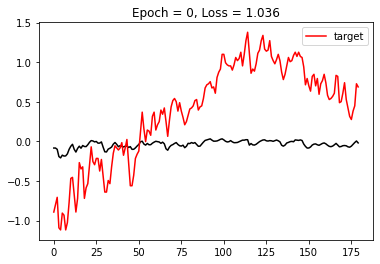

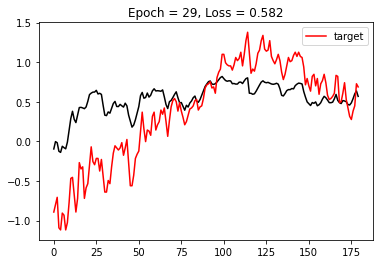

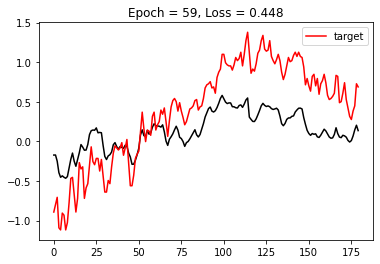

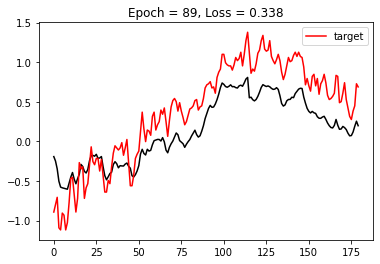

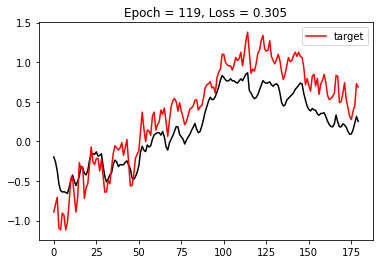

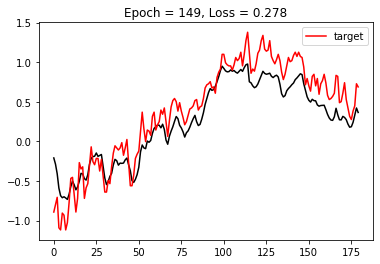

In [6]:
epochs = 150

for i in range(epochs):
    out = model(x)
    loss = loss_fn(y, out)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % int(epochs/5) == 0 or i == 0:
        plt.plot(out.detach()[1], color = 'black')
        plt.plot(y[-455:][1], color = 'red', label = 'target')
        plt.title('Epoch = ' + str(i) + ', Loss = ' + str(np.round(loss.item(), 3)))
        plt.legend()
        plt.pause(0.001);

# Individual conditional expectation plots

*Caveat*: ICE is a local method and I'm only looking at one space-time input, not across the data set. So, these plots look at the effect of varying some feature with respect to this input only. This is still valid, but in some/most instances you probably want to gather more of these lines from other inputs in the data set.

https://christophm.github.io/interpretable-ml-book/ice.html talks about some additional variants that may be worth exploring (but I don't have the time for currently)

In [7]:
# current intended use is for static variables
# REPLACES WHOLE SPATIAL TIME SERIES INPUT WITH ONE VALUE
# (e.g., for one iteration entire network elevation gets set to value X)

def plot_ICE(model, x, var_index, var_name_ls, resolution = 25):
    # assumes model is a trained torch model
    # assumes x is model-ready torch tensor
    #   assumes input is 3D [batch/space, sequence len, vars]
    
    # use matplotlib histogram to get a good grid for ICE values
    bins = plt.hist(x[:, :, var_index].numpy().flatten(), bins = resolution)
    # THIS HISTOGRAM IS ADDITIONALLY USEFUL FOR SEEING WHERE DATA IS
    # MORE ABUNDANTLY PRESENT, HELPS TO CONTEXTUALIZE OR CAUTION THE APPARENT
    # PATTERN WITH INTERVALS THAT ARE 'OUT OF BOUNDS'
    
    pred_ls = []
    # across that grid, replace network static variables
    for val in bins[1]:
        cur_x = x.clone()
        cur_x[:, :, var_index] = torch.as_tensor(val)
        pred = model(cur_x).detach().numpy()
        pred_ls.append(pred)
        
    pred_ls = np.asarray(pred_ls)
    
    plt.pause(0.0001) # so that ICE isn't ontop of hist
    
    # the -1 index is we're just looking at the last day's prediction
    # the "0" index assumes 1 output
    plt.plot(bins[1], pred_ls[:, :, -1, 0], color = 'black', alpha = 0.1)
    plt.xlabel(var_name_ls[var_index])
    plt.ylabel('Prediction')
    plt.plot(bins[1], np.mean(pred_ls[:, :, -1, 0], 1), color = 'yellow', linewidth = 3)
    plt.title("Individual Conditional Expectation Plot");

## Focus on static variables

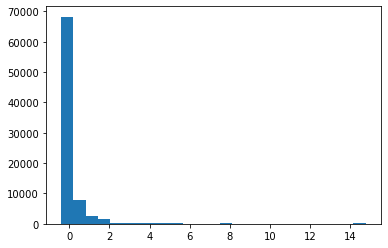

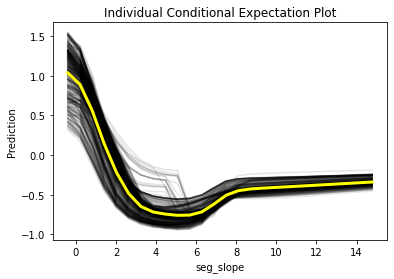

In [8]:
plot_ICE(model, x[-455:], 0, river_dl['x_vars'], 25)

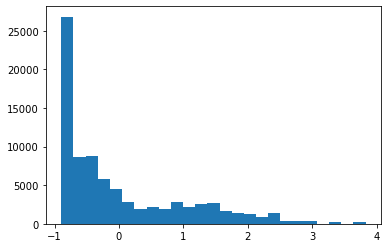

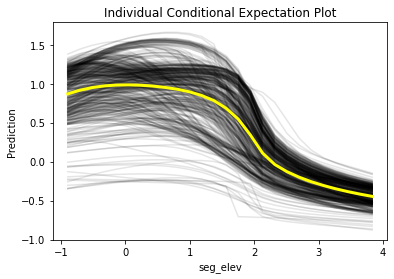

In [9]:
plot_ICE(model, x[-455:], 1, river_dl['x_vars'], 25)

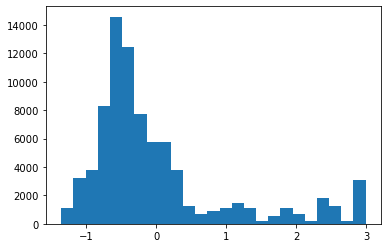

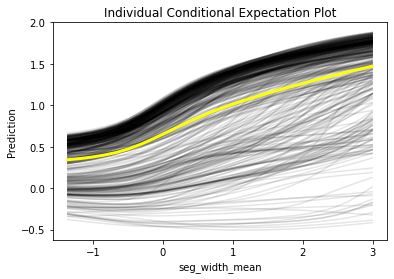

In [10]:
plot_ICE(model, x[-455:], 2, river_dl['x_vars'], 25)

## Non-static variables

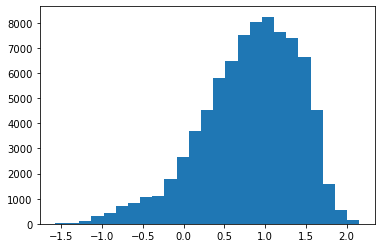

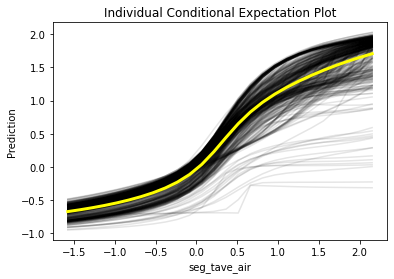

In [11]:
plot_ICE(model, x[-455:], 3, river_dl['x_vars'], 25)

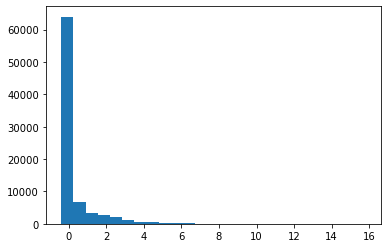

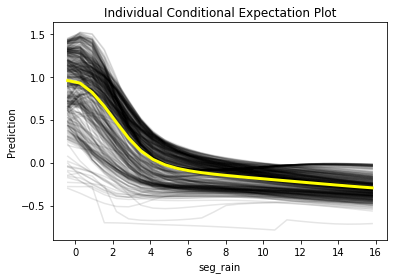

In [12]:
plot_ICE(model, x[-455:], 5, river_dl['x_vars'], 25)